In [2]:
import os
from dotenv import load_dotenv
from image_helper import ImageHelper
from datetime import datetime

load_dotenv()

base_url = os.environ.get("STORAGE_URL")
assert base_url
im_helper = ImageHelper(base_url)

In [3]:
from plantcv import plantcv as pcv
import matplotlib
import numpy as np
class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

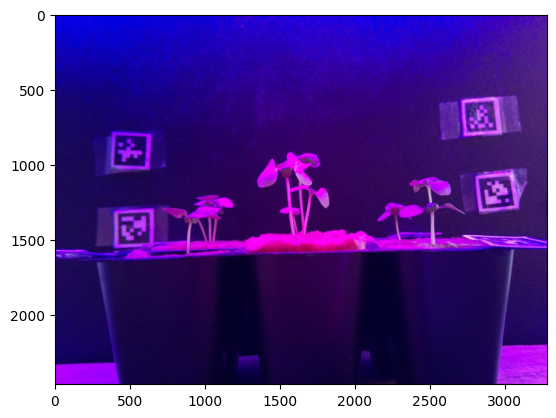

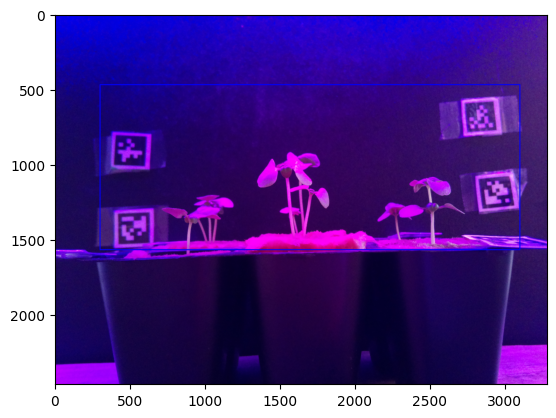

In [4]:
import image_helper
dt_str = '3/12/2022 19:08:18'
dt = im_helper.dt_from_string(dt_str)
assert(im_helper.get(dt, "side"))
img, path, filename = pcv.readimage(im_helper.image.name)
crop_img = pcv.crop(img=img, x=300, y=470, h=1100, w=2800)

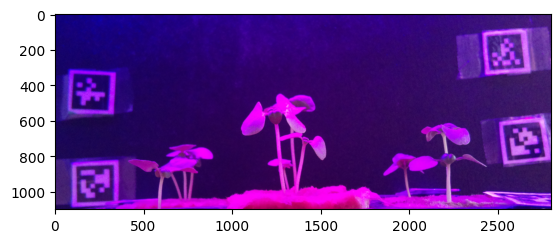

In [5]:
pcv.plot_image(crop_img)

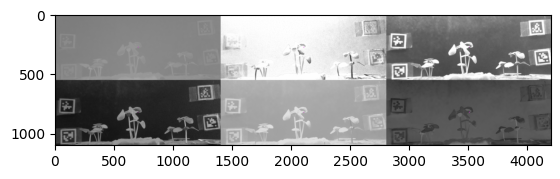

In [6]:
colorspaces = pcv.visualize.colorspaces(rgb_img=crop_img, original_img=False)

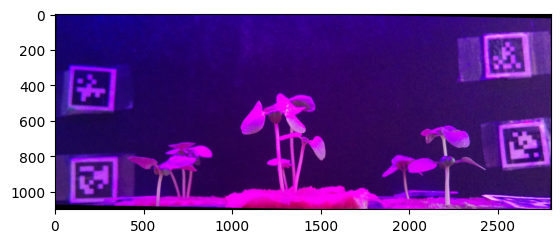

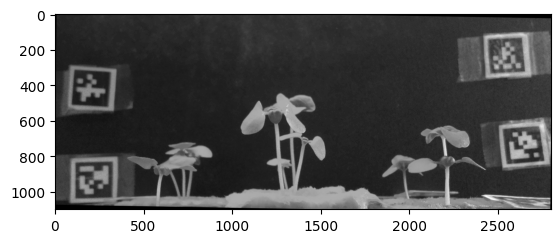

In [7]:
def filter(crop_img):
    rotate_img = pcv.transform.rotate(crop_img, -1, True)
    gray_img = pcv.rgb2gray_lab(rgb_img=rotate_img, channel='l')
    return gray_img

gray_img = filter(crop_img=crop_img)

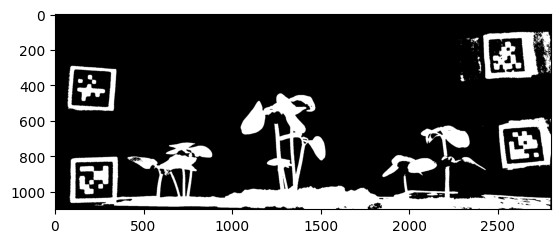

In [8]:
thresh = pcv.threshold.binary(gray_img=gray_img, threshold=90, max_value=255, object_type='light')

In [10]:
def create_mask(gray_img):
    thresh = pcv.threshold.binary(gray_img=gray_img, threshold=80, max_value=255, object_type='light')
    rect_contour1, rect_hierarchy1 = pcv.roi.rectangle(img=gray_img, x=400, y=300, h=800, w=550)
    rect_contour2, rect_hierarchy2 = pcv.roi.rectangle(img=gray_img, x=1000, y=300, h=800, w=550)
    rect_contour3, rect_hierarchy3 = pcv.roi.rectangle(img=gray_img, x=1850, y=400, h=700, w=550)
    rois = [rect_contour1, rect_contour2, rect_contour3]
    roi_hierarchy = [rect_hierarchy1, rect_hierarchy2, rect_hierarchy3]
    roi_mask = pcv.roi.roi2mask(img=gray_img, contour=rois[0])
    for r in rois:
        new_mask = pcv.roi.roi2mask(img=gray_img, contour=r)
        roi_mask = np.maximum(roi_mask, new_mask)
    combined_mask = np.minimum(roi_mask, thresh)
    filled_mask = pcv.fill_holes(bin_img=combined_mask)
    filled_mask = pcv.fill(bin_img=combined_mask, size=200)
    pcv.plot_image(filled_mask)
    return filled_mask, rois, roi_hierarchy

def analyze_shape(rois, roi_hierarchy, crop_img, mask):
    obj, obj_hierarchy = pcv.find_objects(img=img, mask=mask)
    plant_ids = range(0, len(rois))
    img_copy = np.copy(crop_img)
    # Create a for loop to interate through every ROI (plant) in the image
    for i in range(0, len(rois)):
        roi = rois[i]
        hierarchy = roi_hierarchy[i]
        plant_id = plant_ids[i]
        # Subset objects that overlap the ROI
        plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=crop_img, 
                                                                    roi_contour=roi, 
                                                                    roi_hierarchy=hierarchy, 
                                                                    object_contour=obj, 
                                                                    obj_hierarchy=obj_hierarchy, 
                                                                    roi_type="partial")

        # If the plant area is zero then no plant was detected for the ROI
        # and no measurements can be done
        if area > 0:
            # Combine contours together for each plant
            plant_obj, plant_mask = pcv.object_composition(img=crop_img, 
                                                        contours=plant_contours, 
                                                        hierarchy=plant_hierarchy)        
            # Analyze the shape of each plant
            img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                        mask=plant_mask, label=f"plant{plant_id}")
    pcv.plot_image(img_copy)
    return obj, obj_hierarchy


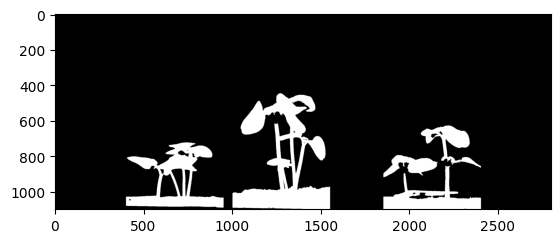

In [11]:
pcv.params.debug = None
mask, rois, roi_hierarchy = create_mask(gray_img)

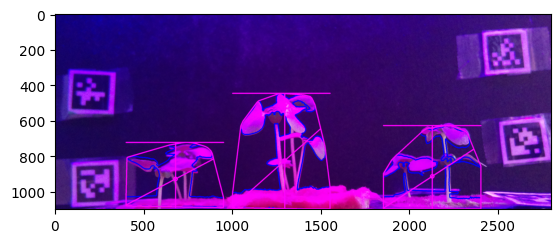

In [12]:
obj, obj_hierarchy = analyze_shape(rois, roi_hierarchy, crop_img, mask)